# Libs and pre-definitions

### Bibliotecas padrões python e utils pytorch

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from collections import defaultdict
from torch.utils.data import random_split
import copy

In [2]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [3]:
import NN_models as models
from NN_models import vgg
import uncertainty.comparison as unc_comp
import uncertainty.quantifications as unc
import uncertainty.losses as losses
import uncertainty.train_and_eval_with_g as TE_g
import NN_utils as utils
import NN_utils.train_and_eval as TE
import NN_utils.cifar_def as pre_data

Files already downloaded and verified
Files already downloaded and verified


## Data download and transforms

In [4]:
train_dataloader, validation_dataloader, test_dataloader = pre_data.get_dataloaders()

In [14]:
class VGG_16(models.Model_CNN):
    def __init__(self,n_classes=10,input = (32,32), pretrained = False, name = 'VGG16'):
        """CNN Builder."""
        super().__init__(n_classes,input,vgg.get_vgg_layers(pretrained),name = name)
        
        self.mask_layer = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=int(16), kernel_size=3, padding='same'),
                nn.BatchNorm2d(int(16)),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=int(16), out_channels=int(32), kernel_size=3, padding='same'),
                nn.Dropout(p=0.2),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, padding='same'),
                nn.Sigmoid())
        self.mask = torch.tensor([0])


    def forward(self, x):
        """Perform forward."""
        self.mask = self.mask_layer(x)
        
        x = self.main_layer(self.mask*x)
        y = self.classifier_layer(x).float()
        return y

In [6]:
PATH = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/'
state_dict_vgg  = torch.load(PATH + 'classifier_vgg.pt')

# Train classifier

In [7]:
loss_criterion = nn.NLLLoss(reduction = 'none')
LEARNING_RATE = 0.1

loss_criterion = nn.NLLLoss()

risk_dict = {'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}


In [18]:
class mask_loss(nn.Module):
    def __init__(self, criterion ,model):
        super().__init__()
        self.criterion = criterion
        self.model = model
        
    def forward(self,y_pred,y_true):
        mask = self.model.mask
        loss_mask = torch.mean(torch.sum(torch.special.entr(mask),dim=-1)+0.1*torch.sum(mask,dim=-1))
        loss = self.criterion(y_pred,y_true)+loss_mask
        return loss

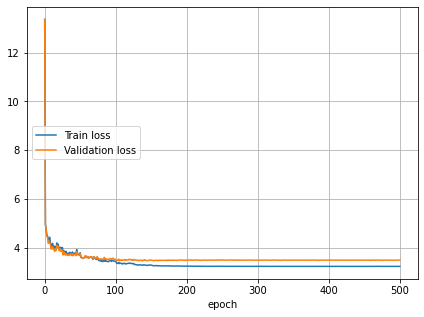

Loss: 3.2384 | Acc_train: 1.00 | Acc_val: 0.93 | Progress:: 100%|#########9| 499/500 [6:45:47<00:48, 48.91s/it…

Conjunto de treinamento: acc =  99.74444444444444
Conjunto de teste: acc =  92.32


In [19]:
model = VGG_16().to(dev)
model.load_state_dict(state_dict_vgg,strict = False)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
loss_criterion = nn.NLLLoss()
loss_fn = mask_loss(loss_criterion, model)

model_trainer = TE.Trainer(model,optimizer,loss_fn, train_dataloader,validation_dataloader,c=0.8,update_lr = (25,2),risk_dict = risk_dict)
model_trainer.fit(train_dataloader,500)

acc = TE.model_acc(model,train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(model,test_dataloader)
print('Conjunto de teste: acc = ', acc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


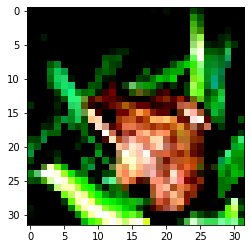

In [22]:
i = 4
image,label = next(iter(test_dataloader))
image,label = image.to(dev), label.to(dev)
image.requires_grad = True
output = torch.exp(model(image))
output_i = output[i]
label_i = label[i]
image_i = image[i].detach().cpu().numpy()
image_i = np.transpose(image_i, (1, 2, 0))
plt.imshow(image_i)

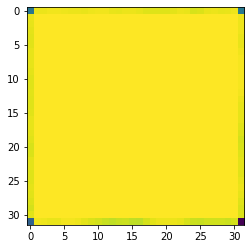

In [23]:
mask_i = model.mask[i]
mask_i = mask_i.detach().cpu().numpy()
mask_i = np.transpose(mask_i, (1, 2, 0))
plt.imshow(mask_i)

In [ ]:
masked_i = mask_i*image_i
masked_i = masked_i/np.max(masked_i)
plt.imshow(masked_i)

In [ ]:
grads = torch.autograd.grad(output_i[label_i],image)[0]

In [ ]:
plt.imshow(image_i*(1-grads_im))

In [ ]:
grads_im = grads[i] - torch.min(grads[i])
grads_im = grads_im/torch.max(grads_im)
grads_im = grads_im.detach().numpy()
grads_im = np.transpose(grads_im, (1, 2, 0))
plt.imshow(grads_im)

## Save models

In [ ]:
import pickle
PATH = r'/home/luis-felipe/Uncertainty_Estimation/torch_models'
PATH_trainer = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/trainer'
SUFIX = '_vgg'
    
model_trainer.hist_val.loss_criterion = None
model_trainer.hist_val.risk_dict = None
model_trainer.hist_train.loss_criterion = None
model_trainer.hist_train.risk_dict = None

torch.save(model.state_dict(), PATH + '/classifier' + SUFIX)
with open(PATH_trainer + r"/hist_val_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer.hist_val,output_file)
with open(PATH_trainer + r"/hist_train_trainer"+SUFIX, "wb") as output_file:
    pickle.dump(model_trainer.hist_train,output_file)

# Plots

In [ ]:
plt.plot(model_trainer_f.hist_val.acc_c_mcp,label = 'MCP')
plt.plot(model_trainer_f.hist_val.acc_list,label = 'ACC_0')
#plt.plot(model_trainer_h.hist_val.acc_c_entropy,label = 'Entropy')
plt.plot(model_trainer_f.hist_val.acc_c_g, label = 'g')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(model_trainer_h.hist_val.acc_c_mcp,label = 'MCP')
plt.plot(model_trainer_h.hist_val.acc_list,label = 'ACC_0')
#plt.plot(model_trainer_h.hist_val.acc_c_entropy,label = 'Entropy')
plt.plot(model_trainer_h.hist_val.acc_c_g, label = 'g')
plt.grid()
plt.legend()
plt.show()

In [ ]:
for key in risk_dict:
    plt.plot(model_trainer_h.hist_val.risk[key],label = key)

plt.grid()
plt.legend()
plt.show()

for key in risk_dict:
    plt.plot(model_trainer_f.hist_val.risk[key],label = key)

plt.grid()
plt.legend()
plt.show()